In [599]:
import numpy as np

def binarize(x):
    probs = 1 / (1 + np.exp(-x))
    return [1 if np.random.random() < p else 0 for p in probs]

class RBM(object):
    '''
    Restricted Boltzmann Machine class holds the function used to learn a dataset and simulation.
    Class attributes are:
    
    '''
    def __init__(self, connections, activations=None):
        '''
        Initialize RBM attributes
        - connections: list-like structure containing the connection matrices
                       between layers, starting from the visible layer
                       (that is, the firs matrix maps the input layer to the first
                        hidden layer, and it has as many rows as neurons in the
                        input layer and as many columns as neurons in the first
                        hidden layer)
        
        
        '''
        for i in range(len(connections)-1):
            if connections[i].shape[1] != connections[i+1].shape[0]:
                raise ValueError('Incompatible dimension for connection matrices')
        self.connections = np.array(connections)
        
        self.layer_state = np.array([[0.]*w.shape[0]
                                     for w in connections] +
                                    [[0.]*connections[-1][2]])
        self.biases = self.layer_state.copy()
        
        if activations is None:
            self.activations = [lambda x: x] * len(self.layer_state)
        elif len(connections) != len(activations):
            raise ValueError('Incompatibledimensions for connections and activations')
        else:
            self.activations = activations
        
    def _energy(self, level):
        '''
        Computes the energy of one layer
        Input
        - level: number of layer (from 0, which is visible layer to num_layers - 1)
        '''       
        ##TODO add check on level value
        return -np.dot(np.dot(self.layer_state[level], self.connections[level]),
                       np.transpose(self.layer_state[level+1])) \
               - np.dot(self.layer_state[level], self.biases[level])
   
    def energy(self):
        return sum([self._energy(level) for level in range(len(self.connections))]) \
               - np.dot(self.layer_state[-1], self.biases[-1])
               # this last contribution is for the bias of last hidden layer
    
    def run_from_visible(self, v, verbose=False, starting_layer=1):
        '''encodes a visible vector
           - v: vector to be encoded
           - starting_layer: layer from which the propagation is started
                             (default: 1, which means visible layer; 2 would
                              mean first hidden layer and so on)
        '''
        if len(v) != len(self.layer_state[0]):
            raise ValueError('Specified visible layer is incoherent')
        self.layer_state[0] = np.array(v)
        for level in range(starting_layer, len(self.layer_state)):
            if verbose:
                print('  from visible now in level {}'.format(level-1))
                #print('matrix is {}x{}, vector is {}'.format(self.connections[level-1].shape[0],
                #                                             self.connections[level-1].shape[1],
                #                                             len(self.layer_state[level-1])))
            self.layer_state[level] = self.activations[level](np.dot(self.connections[level-1].T, self.layer_state[level-1]) \
                                                              + self.biases[level])
        return self.layer_state[-1]
    
    def run_from_hidden(self, h, verbose=False, starting_layer=1):
        '''reconstruct from an hidden vector
           - h: hidden vector
           - starting_layer: layer from which the propagation is started
                             (default: 1, which means last hidden layer; 2 would
                              mean second-last hidden layer and so on)
        '''
        if len(h) != len(self.layer_state[-1]):
            raise ValueError('Specified hidden layer is incoherent')
        self.layer_state[-1] = np.array(h)
        for level in range(len(self.layer_state)-starting_layer)[::-1]:
            if verbose:
                print('  from hidden now in level {}'.format(level+1))
                #print('matrix is {}x{}, vector is {}'.format(self.connections[level].shape[0],
                #                                             self.connections[level].shape[1],
                #                                             len(self.layer_state[level+1])))
            self.layer_state[level] = self.activations[level](np.dot(self.connections[level], self.layer_state[level+1]) \
                                                              + self.biases[level])
        
        self.layer_state[0] = binarize(self.layer_state[0])    
        return self.layer_state[0]

In [601]:
class TransductiveRBM(object):
    
    def __init__(self, w, activations=None):
        m = w.shape[1]
        i = np.eye(m)
        self.rbm = RBM([w, i], activations)
        # self.rbm.biases[1] = [0] * m #as already done in RBM constructor
    
    def grad_h_middle(self, v, h_0):
        v_1 = self.rbm.run_from_hidden(h_0, starting_layer=2)
        h_1 = self.rbm.run_from_visible(v_1)
        return (np.dot(self.rbm.connections[0].T, v) - \
                np.dot(self.rbm.connections[0].T, v_1)) + \
               (h_0 - h_1)
    
    def grad_bias_visible(self, v, h_0):
        v_1 = self.rbm.run_from_hidden(h_0)
        return v - v_1
    
    def grad_bias_hidden(self, h_0):
        v_1 = self.rbm.run_from_hidden(h_0, starting_layer=2)
        h_1 = self.rbm.run_from_visible(v_1)
        return h_0 - h_1
    
    def fit(self, v, use_bias=False, learning_rate=0.1, learning_rate_decay=0.998,
            max_iterations=3000, delta_max=10**-3,
            verbose=False):
        num_iter = 0
        old_h_middle = self.rbm.layer_state[1]
        curr_delta = delta_max * 1.1 # to ensure next loop is always entered
        energy_vals = []
        while num_iter < max_iterations and curr_delta > delta_max: 
            h_0 = self.rbm.run_from_visible(v, starting_layer=2)
            #print('next learning iteration-----')
            #print('grad h middle:')
            self.rbm.layer_state[1] -= learning_rate * self.grad_h_middle(v, h_0)
            #print('variation: {}'.format(learning_rate * self.grad_h_middle(v, h_0)))
            if use_bias:
                #print('grad bias visible:')
                self.rbm.biases[0] -= learning_rate * self.grad_bias_visible(v, h_0)
                #print('grad bias hidden:')
                self.rbm.biases[-1] -= learning_rate * self.grad_bias_hidden(h_0)
            curr_delta = np.max(np.abs(self.rbm.layer_state[1] - old_h_middle))
            old_h_middle = self.rbm.layer_state[1]
            num_iter += 1
            learning_rate *= learning_rate_decay
            if verbose:
                #print('iteration {}, delta={}'.format(num_iter, curr_delta))
                #print('----->h={}'.format(str(self.rbm.layer_state[1])))
                pass
            energy_vals.append(self.rbm.energy())
        
        return energy_vals
        

In [557]:
n = 25
m = 10
w = np.random.random((n, m))


trbm = TransductiveRBM(w)

In [558]:
energy = trbm.fit(np.random.randint(2, size=n), learning_rate=1, use_bias=True, delta_max=10**-3, verbose=True)

  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-17.00679246 -15.30513013 -21.4381916  -22.14247575 -21.24011809
 -19.09534372 -18.54253043 -22.33473895 -17.51579628 -18.1182507 ]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1, delta=6.331030719399377
----->h=[5.40091497 4.10704474 5.97071934 6.33103072 6.29127783 6.19634755
 6.10963988 6.00379099 5.4488641  5.36796277]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation:

grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 80, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 81, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.7201356

variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 146, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 225, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now 

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 308, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now 

  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 387, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variatio

  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 461, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 462, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.

  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 538, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variatio

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 617, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now 

  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 701, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5

  from visible now in level 0
  from visible now in level 1
iteration 784, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 785, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1


  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 865, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 945, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now 

  from visible now in level 0
  from visible now in level 1
iteration 1021, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1022, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 

  from visible now in level 0
  from visible now in level 1
iteration 1100, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1101, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 

  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1171, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad b

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1251, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1335, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1336, delta=8.0

  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1412, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -

  from visible now in level 0
  from visible now in level 1
iteration 1495, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1496, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 

  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1576, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -

  from visible now in level 1
iteration 1652, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1653, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1741, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 1
iteration 1823, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1824, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1906, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 1988, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible no

  from visible now in level 1
iteration 2070, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2071, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----

  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2137, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -

  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2209, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variati

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2290, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2367, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2439, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2523, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2607, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2689, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2690, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.720

  from visible now in level 0
  from visible now in level 1
iteration 2766, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2767, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 

  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2847, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now

  from visible now in level 0
  from visible now in level 1
iteration 2923, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 1
next learning iteration-----
grad h middle:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
variation: [-5.93085502 -5.59839084 -7.73086952 -7.46250475 -8.01439524 -5.82494449
 -6.44058714 -7.42710481 -5.79566064 -5.45852001]
grad bias visible:
  from hidden now in level 2
  from hidden now in level 1
grad bias hidden:
  from hidden now in level 1
  from visible now in level 0
  from visible now in level 1
iteration 2924, delta=8.014395240703854
----->h=[11.07593744  9.70673929 13.70732208 14.679971   13.22572285 13.27039922
 12.10194329 14.90763414 11.72013564 12.65973069]
  from visible now in level 

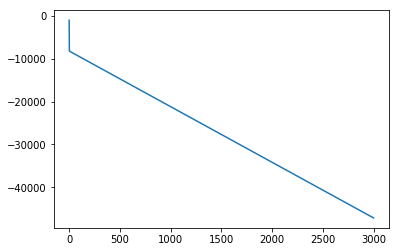

In [559]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(range(len(energy)), energy)
plt.show()

In [525]:
str(trbm.rbm.layer_state[1])

'[0.00474543 0.00410844 0.00456336 0.00402088 0.00506288]'

In [381]:
trbm.rbm.biases

array([array([ 0. ,  0. ,  0. , -0.1,  0. , -0.1, -0.1,  0. , -0.1,  0. ]),
       list([0.0, 0.0, 0.0, 0.0, 0.0]),
       array([0.24833847, 0.70536757, 0.51691514, 0.47977264, 0.497933  ])],
      dtype=object)

In [357]:
trbm.rbm.layer_state

array([array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1]),
       array([2.84419282, 2.61615232, 5.42415979, 3.74220532, 3.88038719]),
       array([2.84419282, 2.61615232, 5.42415979, 3.74220532, 3.88038719])],
      dtype=object)

In [382]:
a = np.array((9, 3, -1))

## Usiamo i dati veri

In [561]:
def load_data(filename, separator=' '):
    '''
    Read file with data set, one object per line expressed as space separated integer values
    
    Input
    - filename: string containing the pathname of the file to be read
    - separator: character dividing the columns of the input dataset; default being whitespace
    
    Returns an array of lists
    '''
    with open(filename) as f:
        input_values = [line.strip("\n\r").split(separator) for line in f.readlines()]
    return np.array(input_values).astype(int)

def load_weights(filename, separator=' '):
    '''
    Read file with data set, one object per line expressed as space separated integer values
    
    Input
    - filename: string containing the pathname of the file to be read
    - separator: character dividing the columns of the input dataset; default being whitespace
    
    Returns an array of lists containing the weights saved in the file
    '''

    with open(filename) as f:
        input_values = [line.strip("\n\r").split(separator) for line in f.readlines()]
    return np.array(input_values).astype(float)

In [575]:
data_path = '/home/malchiodi/oldocs/ricerca/rbm/rbm_tesi/src/options/new-dataset/yeast.GOA.ann.9.may.17.onto.CC.tsv'
weight_path = '/home/malchiodi/oldocs/ricerca/rbm/rbm_tesi/src/options/new-dataset/yeast.STRING.v10.5.net_no_labels.tsv'

labels = load_data(data_path, '\t')
weights = load_weights(weight_path, '\t')



In [606]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

def extract_matrix(m, rows, cols):
    row_idx = np.array(rows)
    col_idx = np.array(cols)
    return m[row_idx[:, None], col_idx]

num_folds = 3 
kf = StratifiedKFold(n_splits=num_folds)
avg_roc = np.array([0.]*labels.T.shape[0])
avg_prc = np.array([0.]*labels.T.shape[0])


for _class in range(labels.T.shape[0]):
    auroc_values = []
    prc_values = []
    num_fold = 1

    expected_all = labels.T[_class]
    for indices_train, indices_test in kf.split(expected_all, expected_all):
        #print("%s %s" % (train, test))
        labels_train = labels[indices_train]
        labels_test = labels[indices_test]
        weights_fold = extract_matrix(weights, indices_train, indices_test)
        trbm = TransductiveRBM(weights_fold)      
    
        trbm.fit(labels_train.T[_class], learning_rate=10, delta_max=5*10**-2)
        pred = trbm.rbm.layer_state[-1]
        expected = labels_test.T[_class]
        auroc = metrics.roc_auc_score(expected, pred)
        auroc_values.append(auroc)
        
        precision, recall, _ = metrics.precision_recall_curve(expected, pred)
        prc = metrics.auc(recall, precision)
        prc_values.append(prc)
        print('    class {}, fold {}: avg roc={}, avg prc={}'.format(_class,
                                                                     num_fold,
                                                                     auroc,
                                                                     prc))
        
        num_fold += 1
    avg_roc[_class] += np.average(auroc_values)
    avg_prc[_class] += np.average(prc_values)
    print('class {}: avg roc={}, avg prc={}'.format(_class, sum_roc[_class], sum_prc[_class]))



    class 0, fold 1: avg roc=0.611896533668447, avg prc=0.00500769499606992
    class 0, fold 2: avg roc=0.6072887213320766, avg prc=0.0068442483227947985
    class 0, fold 3: avg roc=0.5111975483262612, avg prc=0.003580731285336062
class 0: avg roc=0.0, avg prc=0.0
    class 1, fold 1: avg roc=0.7708039492242594, avg prc=0.004326415973542305
    class 1, fold 2: avg roc=0.7380112834978844, avg prc=0.003282869054609277
    class 1, fold 3: avg roc=0.8377234242709313, avg prc=0.004014796684319712
class 1: avg roc=0.0, avg prc=0.0
    class 2, fold 1: avg roc=0.8425751140475067, avg prc=0.018597442326823126
    class 2, fold 2: avg roc=0.8777541706011961, avg prc=0.02647368765811661
    class 2, fold 3: avg roc=0.8399039974819011, avg prc=0.017724749942860787
class 2: avg roc=0.0, avg prc=0.0
    class 3, fold 1: avg roc=0.8820468584784907, avg prc=0.03250956470041603
    class 3, fold 2: avg roc=0.8324892871055707, avg prc=0.0218394301457909
    class 3, fold 3: avg roc=0.85698651206814

    class 30, fold 3: avg roc=0.8865239887111948, avg prc=0.009619425287314687
class 30: avg roc=0.0, avg prc=0.0
    class 31, fold 1: avg roc=0.7044705882352941, avg prc=0.00460071617525795
    class 31, fold 2: avg roc=0.7761568627450981, avg prc=0.009734227640668447
    class 31, fold 3: avg roc=0.8629001883239171, avg prc=0.0088363990368713
class 31: avg roc=0.0, avg prc=0.0
    class 32, fold 1: avg roc=0.5766920844861326, avg prc=0.007948636859283207
    class 32, fold 2: avg roc=0.5647479587016668, avg prc=0.006786444141050379
    class 32, fold 3: avg roc=0.688308855605642, avg prc=0.01529717295923164
class 32: avg roc=0.0, avg prc=0.0
    class 33, fold 1: avg roc=0.8388905502392344, avg prc=0.029251807676158925
    class 33, fold 2: avg roc=0.7817198135081902, avg prc=0.02418293497124952
    class 33, fold 3: avg roc=0.8045575805928844, avg prc=0.030088184636062786
class 33: avg roc=0.0, avg prc=0.0
    class 34, fold 1: avg roc=0.5525289211729889, avg prc=0.0033201754118472

    class 61, fold 2: avg roc=0.5079529411764706, avg prc=0.002187031402755054
    class 61, fold 3: avg roc=0.5882352941176471, avg prc=0.0028585305976882606
class 61: avg roc=0.0, avg prc=0.0
    class 62, fold 1: avg roc=0.5606775300171527, avg prc=0.005339524645046921
    class 62, fold 2: avg roc=0.6366981132075471, avg prc=0.0066439150865106695
    class 62, fold 3: avg roc=0.6407075471698113, avg prc=0.007922396396281286
class 62: avg roc=0.0, avg prc=0.0
    class 63, fold 1: avg roc=0.730573847601129, avg prc=0.005774142473504662
    class 63, fold 2: avg roc=0.8912511759172153, avg prc=0.009812618115939413
    class 63, fold 3: avg roc=0.9750588235294118, avg prc=0.03699286763167861
class 63: avg roc=0.0, avg prc=0.0
    class 64, fold 1: avg roc=0.6375686274509803, avg prc=0.006357182401603477
    class 64, fold 2: avg roc=0.623587570621469, avg prc=0.00440744552299595
    class 64, fold 3: avg roc=0.6105618330194601, avg prc=0.0033399551936557697
class 64: avg roc=0.0, avg 

    class 92, fold 1: avg roc=0.6417733522996681, avg prc=0.016116728872952464
    class 92, fold 2: avg roc=0.6193505261342074, avg prc=0.012347397297151936
    class 92, fold 3: avg roc=0.5358590650336381, avg prc=0.00999428275486042
class 92: avg roc=0.0, avg prc=0.0
    class 93, fold 1: avg roc=0.6318246110325318, avg prc=0.007050755111193281
    class 93, fold 2: avg roc=0.7307349782597307, avg prc=0.00834092773024011
    class 93, fold 3: avg roc=0.7977369165487977, avg prc=0.0281201997449679
class 93: avg roc=0.0, avg prc=0.0
    class 94, fold 1: avg roc=0.6479770716233513, avg prc=0.010239421019585459
    class 94, fold 2: avg roc=0.49674439312148694, avg prc=0.007222837372725766
    class 94, fold 3: avg roc=0.6419190724088973, avg prc=0.010263984891147854
class 94: avg roc=0.0, avg prc=0.0
    class 95, fold 1: avg roc=0.46062529384109074, avg prc=0.0015897538041042152
    class 95, fold 2: avg roc=0.6774459078080903, avg prc=0.0026456511253131814
    class 95, fold 3: avg 

    class 122, fold 1: avg roc=0.5814675446848542, avg prc=0.0025415474744258084
    class 122, fold 2: avg roc=0.7028222013170273, avg prc=0.004085893188349775
    class 122, fold 3: avg roc=0.6604705882352941, avg prc=0.002706601750493959
class 122: avg roc=0.0, avg prc=0.0
    class 123, fold 1: avg roc=0.5416558338388653, avg prc=0.016598609303014517
    class 123, fold 2: avg roc=0.5840085795996187, avg prc=0.021198841296154507
    class 123, fold 3: avg roc=0.4938185176358436, avg prc=0.013325731219686821
class 123: avg roc=0.0, avg prc=0.0
    class 124, fold 1: avg roc=0.6980244590780809, avg prc=0.003513902013031559
    class 124, fold 2: avg roc=0.7746823529411765, avg prc=0.00494973620067244
    class 124, fold 3: avg roc=0.6200470588235294, avg prc=0.0031749421040919586
class 124: avg roc=0.0, avg prc=0.0
    class 125, fold 1: avg roc=0.687958607714017, avg prc=0.0034017509449879827
    class 125, fold 2: avg roc=0.7575258701787394, avg prc=0.003627438870630367
    class 1

    class 152, fold 1: avg roc=0.47890196078431374, avg prc=0.04376748928412696
    class 152, fold 2: avg roc=0.7202823529411765, avg prc=0.006373132296025076
    class 152, fold 3: avg roc=0.6875294117647059, avg prc=0.003484269481259996
class 152: avg roc=0.0, avg prc=0.0
    class 153, fold 1: avg roc=0.45774426641533145, avg prc=0.003499482599567263
    class 153, fold 2: avg roc=0.2933291444130275, avg prc=0.002770756067181093
    class 153, fold 3: avg roc=0.4123644507307873, avg prc=0.002893428122940663
class 153: avg roc=0.0, avg prc=0.0
    class 154, fold 1: avg roc=0.7143864598025388, avg prc=0.003166493817052067
    class 154, fold 2: avg roc=0.5886224729666196, avg prc=0.010264018665976284
    class 154, fold 3: avg roc=0.763986835919135, avg prc=0.0228570251268568
class 154: avg roc=0.0, avg prc=0.0
    class 155, fold 1: avg roc=0.6601803512102515, avg prc=0.01817308441707421
    class 155, fold 2: avg roc=0.6312094605283973, avg prc=0.015064713000444239
    class 155, 

In [594]:
from sklearn.model_selection import StratifiedKFold
X = [0]*7 + [1]*3

num_folds = 3 
kf = StratifiedKFold(n_splits=num_folds)

for indices_train, indices_test in kf.split(X, X):
    print("%s %s" % (indices_train, indices_test))

[3 4 5 6 8 9] [0 1 2 7]
[0 1 2 5 6 7 9] [3 4 8]
[0 1 2 3 4 7 8] [5 6 9]
